In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import ndcg_score
from collections import defaultdict, Counter
import ast
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from numpy import where
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import itertools

In [2]:
# Load the datasets
small = pd.read_csv('data/small_matrix.csv')
big = pd.read_csv('data/big_matrix.csv')
categories = pd.read_csv('data/item_categories.csv')
item_daily_features = pd.read_csv('data/item_daily_features.csv')
caption = pd.read_csv('data/kuairec_caption_category.csv', encoding='utf-8',
    na_values=[],
    keep_default_na=False,
    on_bad_lines='skip',   # skip problematic rows
    engine='python')
# user = pd.read_csv('data/user_features.csv')
# social = pd.read_csv('data/social_network.csv')

For this project i decided to use content based filtering to create my recommendation model. Therefore i'll not use the user and social dataset that give features for user (more adequate for a collaborative filtering)

# **1) Data Analysis**

## small_matrix & big_matrix

<p align="center">
    <img width="721" alt="cover-image" src="pics/small_big.webp">
</p>

This a description done in a research paper on the dataset (https://arxiv.org/pdf/2202.10842)

As it is shown, we can see that the small_matrix has a bigger density than the big one (in the small matrix all users interacts with all the videos). The small matrix is then very intersting as a test set for our recommendation model, big will then be the train set.

In [3]:
# Small matrix represents all the interactions between users and items as the big one
print(small.head())
print(big.head())


   user_id  video_id  play_duration  video_duration                     time  \
0       14       148           4381            6067  2020-07-05 05:27:48.378   
1       14       183          11635            6100  2020-07-05 05:28:00.057   
2       14      3649          22422           10867  2020-07-05 05:29:09.479   
3       14      5262           4479            7908  2020-07-05 05:30:43.285   
4       14      8234           4602           11000  2020-07-05 05:35:43.459   

         date     timestamp  watch_ratio  
0  20200705.0  1.593898e+09     0.722103  
1  20200705.0  1.593898e+09     1.907377  
2  20200705.0  1.593898e+09     2.063311  
3  20200705.0  1.593898e+09     0.566388  
4  20200705.0  1.593899e+09     0.418364  
   user_id  video_id  play_duration  video_duration                     time  \
0        0      3649          13838           10867  2020-07-05 00:08:23.438   
1        0      9598          13665           10984  2020-07-05 00:13:41.297   
2        0      5262 

In [4]:
num_interactions_s = small.shape[0]
num_unique_users_s = small['user_id'].nunique()
num_unique_videos_s = small['video_id'].nunique()
print("prout", small['timestamp'].max())
small['timestamp'] = pd.to_datetime(small['timestamp'], unit='s')
print("Stats of small_matrix:")
print(f"Number of interactions: {num_interactions_s}")
print(f"Number of unique users: {num_unique_users_s}")
print(f"Number of unique videos: {num_unique_videos_s}")
print(f"Min timestamp: {small['timestamp'].min()}")
print(f"Max timestamp: {small['timestamp'].max()}")
print("----------------------")

num_interaction_b = big.shape[0]
num_unique_users_b = big['user_id'].nunique()
num_unique_videos_b = big['video_id'].nunique()
big['timestamp'] = pd.to_datetime(big['timestamp'], unit='s')
print("Stats of big_matrix:")
print(f"Number of interactions: {num_interaction_b}")
print(f"Number of unique users: {num_unique_users_b}")
print(f"Number of unique videos: {num_unique_videos_b}")
print(f"Min timestamp: {big['timestamp'].min()}")
print(f"Max timestamp: {big['timestamp'].max()}")
print("----------------------")

# Check if the video_isd in small is in big
print("Checking that small is a subset of big:")
small_video_ids = set(small['video_id'].unique())
big_video_ids = set(big['video_id'].unique())
print("Number of videos in small not in big: ", len(small_video_ids - big_video_ids))
# Check if the user_id in small is in big
small_user_ids = set(small['user_id'].unique())
big_user_ids = set(big['user_id'].unique())
print("Number of users in small not in big: ", len(small_user_ids - big_user_ids))

prout 1599321443.683
Stats of small_matrix:
Number of interactions: 4676570
Number of unique users: 1411
Number of unique videos: 3327
Min timestamp: 2020-07-03 18:23:26.059999943
Max timestamp: 2020-09-05 15:57:23.683000088
----------------------
Stats of big_matrix:
Number of interactions: 12530806
Number of unique users: 7176
Number of unique videos: 10728
Min timestamp: 2020-06-23 00:34:11.372999907
Max timestamp: 2020-09-09 23:32:12.427000046
----------------------
Checking that small is a subset of big:
Number of videos in small not in big:  0
Number of users in small not in big:  0


We have confirm what the research paper was saying about big & small matrix, we can now start to analyse how the data is distributed and see what are the intersting informations.

First we can observe some redundance in those interactions dataset, time, date and timestamp represents the same information in different format. We will keep timestamp because we already used it before

In [5]:
small.drop(columns=['date', 'time'], inplace=True)
big.drop(columns=['date', 'time'], inplace=True)
print(small.dtypes)
print(big.dtypes)

user_id                    int64
video_id                   int64
play_duration              int64
video_duration             int64
timestamp         datetime64[ns]
watch_ratio              float64
dtype: object
user_id                    int64
video_id                   int64
play_duration              int64
video_duration             int64
timestamp         datetime64[ns]
watch_ratio              float64
dtype: object


**Big** matrix is going to be used during the training to determine the profil of a user so that we can accuratly select the videos to put in our content based model. If we don't succeed to correctly understand the profil of the user even though our content base model will work the recommended video will not be accurate for the user.

What can we get from **big** matrix, that can describe our user liking ?
- video_duration -> to get the format of the video (short video, long video...)
- watch_ratio -> to know if the user liked it or not
- timestamp -> to know when the user last watched it

### a) Video duration Analysis

Distribution of video duration (in minutes) in big:
Min video duration:  0.023333333333333334
Max video duration:  52.512
Mean video duration:  2.4369278407284107
Median video duration:  1.606


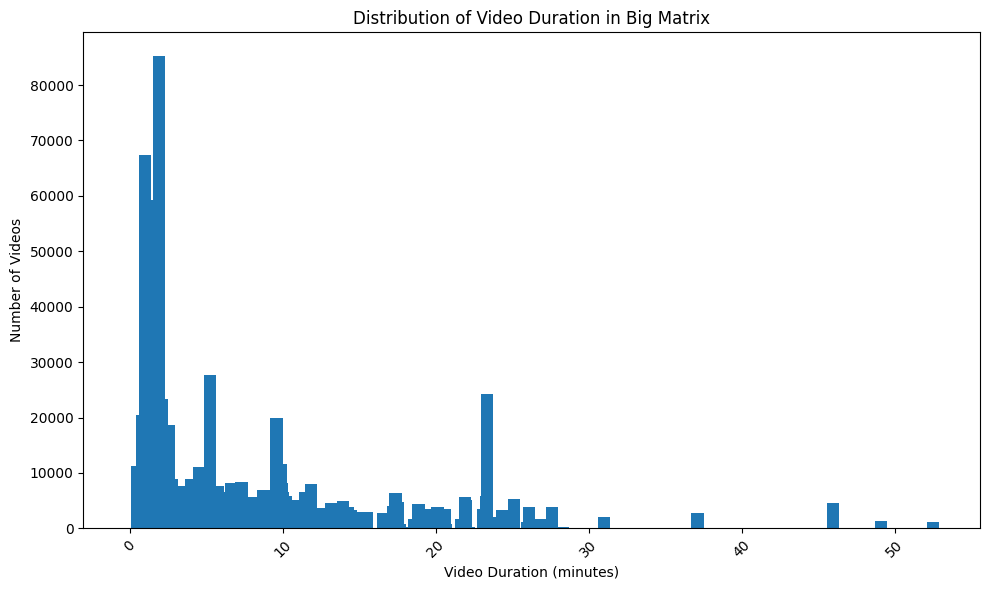

In [7]:
# Get the distribution of video_duration in big in minutes
video_duration = big['video_duration'] / 6000
print("Distribution of video duration (in minutes) in big:")
print("Min video duration: ", video_duration.min())
print("Max video duration: ", video_duration.max())
print("Mean video duration: ", video_duration.mean())
print("Median video duration: ", video_duration.median())
duration_distribution = big.groupby(big['video_duration']).size().reset_index(name='counts')
duration_distribution = duration_distribution.sort_values(by='video_duration')
duration_distribution['video_duration'] = duration_distribution['video_duration'] / 6000

plt.figure(figsize=(10, 6))
plt.bar(duration_distribution['video_duration'], duration_distribution['counts'])
plt.xlabel('Video Duration (minutes)')
plt.ylabel('Number of Videos')
plt.title('Distribution of Video Duration in Big Matrix')
plt.xticks(rotation=45)
plt.tight_layout()

We can see that user tends to interact much more with short videos. Therefore if we use the time duration as a feature later on we should be more sensible with short video than long. For example we can class video into more than 25min, 15min, 8min... and more we get close to short duration more ofthen we split the time (1min, 45sec, 30sec...)

In [ ]:
# Script to balance the distribution of videos in time range category
# Script to balance the distribution of interactions in time range category (suffixed by interact)
df_sorted_interact = duration_distribution.sort_values("video_duration").reset_index(drop=True)
duration_distrib_unique_vid = big.groupby(big['video_id']).aggregate({
    'video_duration': 'first',
    'watch_ratio': 'first'
}).reset_index()
duration_distrib_unique_vid.columns = ['video_id', 'video_duration', 'counts']
duration_distrib_unique_vid['counts'] = 1
duration_distrib_unique_vid['video_duration'] = duration_distrib_unique_vid['video_duration'] / 6000
df_sorted = duration_distrib_unique_vid.sort_values("video_duration").reset_index(drop=True)

df_sorted["cum_counts"] = df_sorted["counts"].cumsum()
df_sorted_interact["cum_counts"] = df_sorted_interact["counts"].cumsum()

total_counts = df_sorted["counts"].sum()
total_counts_interact = df_sorted_interact["counts"].sum()
n_bins = 10
counts_per_bin = total_counts / n_bins
counts_per_bin_interact = total_counts_interact / n_bins

# Define bin edges
bin_edges = [df_sorted["video_duration"].min()]
bin_edges_interact = [df_sorted_interact["video_duration"].min()]
for i in range(1, n_bins):
    target = i * counts_per_bin
    idx = (df_sorted["cum_counts"] >= target).idxmax()
    edge = df_sorted.loc[idx, "video_duration"]
    bin_edges.append(edge)

for i in range(1, n_bins):
    target = i * counts_per_bin_interact
    idx = (df_sorted_interact["cum_counts"] >= target).idxmax()
    edge = df_sorted_interact.loc[idx, "video_duration"]
    bin_edges_interact.append(edge)

bin_edges.append(df_sorted["video_duration"].max())
bin_edges_interact.append(df_sorted_interact["video_duration"].max())

# Assign bin labels
df_sorted["duration_bin"] = pd.cut(df_sorted["video_duration"], bins=bin_edges, include_lowest=True)
df_sorted_interact["duration_bin"] = pd.cut(df_sorted_interact["video_duration"], bins=bin_edges_interact, include_lowest=True)

# Optional: check total counts per bin
bin_counts = df_sorted.groupby("duration_bin")["counts"].sum()
bin_counts_interact = df_sorted_interact.groupby("duration_bin")["counts"].sum()

# print("Bin edges:", bin_edges)
print("Balanced distribution of video in time range category (considering the videos):\n", bin_counts)
print("--------------------")
print("Balanced distribution of video in time range category (considering the interactions):\n", bin_counts_interact)

Balanced distribution of video in time range category (considering the videos):
 duration_bin
(0.0223, 0.806]    1074
(0.806, 1.006]     1094
(1.006, 1.167]     1059
(1.167, 1.339]     1087
(1.339, 1.529]     1051
(1.529, 1.734]     1073
(1.734, 1.922]     1075
(1.922, 2.272]     1070
(2.272, 3.344]     1074
(3.344, 52.507]    1071
Name: counts, dtype: int64
--------------------
Balanced distribution of video in time range category (considering the interactions):
 duration_bin
(0.0223, 1.011]    1259860
(1.011, 1.172]     1280381
(1.172, 1.316]     1222295
(1.316, 1.467]     1267015
(1.467, 1.606]     1240811
(1.606, 1.756]     1253300
(1.756, 1.922]     1299090
(1.922, 2.266]     1204666
(2.266, 4.04]      1250781
(4.04, 52.512]     1252607
Name: counts, dtype: int64


/tmp/ipykernel_9867/2214956413.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_sorted.groupby("duration_bin")["counts"].sum()
/tmp/ipykernel_9867/2214956413.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts_interact = df_sorted_interact.groupby("duration_bin")["counts"].sum()


Later on we will use this data of distribution to selection time range category for our feature selection

### b) Watch Ratio Analysis

Distribution of watch_ratio in big:
Min watch_ratio:  0.0
Max watch_ratio:  573.46
Mean watch_ratio:  0.9445049440554749
Median watch_ratio:  0.72


/tmp/ipykernel_150502/3378918690.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df)


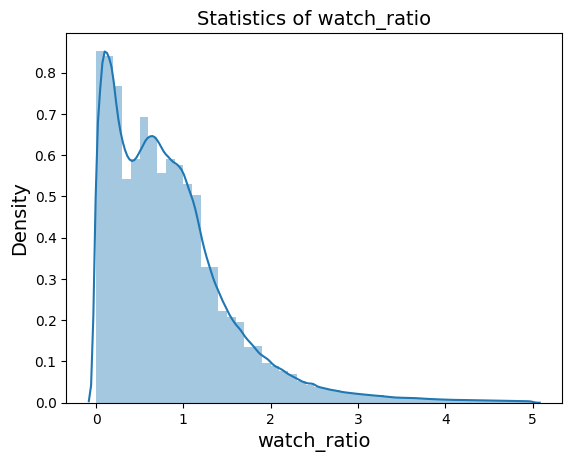

In [6]:
# Get the watch_ratio distribution on big
# Only keep 2 floating point digits in watch_ratio
big['watch_ratio'] = big['watch_ratio'].apply(lambda x: round(float(x), 2))
watch_ratio = big['watch_ratio']
print("Distribution of watch_ratio in big:")
print("Min watch_ratio: ", watch_ratio.min())
print("Max watch_ratio: ", watch_ratio.max())
print("Mean watch_ratio: ", watch_ratio.mean())
print("Median watch_ratio: ", watch_ratio.median())

def visual_continue(df, func=None):
    ax = sns.distplot(df)
    if func:
        func(ax)
    
    gca = plt.gca()
    fig_title = "Statistics of {}".format(df.name)
    gca.set_title(fig_title, fontsize=14)
    gca.set_ylabel("Density", fontsize=14)
    gca.set_xlabel(df.name, fontsize=14)
    
    plt.show()

visual_continue(big.watch_ratio[big.watch_ratio <= 5])

We will use this distribution to help us determine at what threshold we consider that a user likes a video. A first approach could be the median at 0.72

### Timestamp analysis

Minimun timestamp :2020-06-23 00:34:11.372999907
Maximum timestamp :2020-09-09 23:32:12.427000046
ploting...


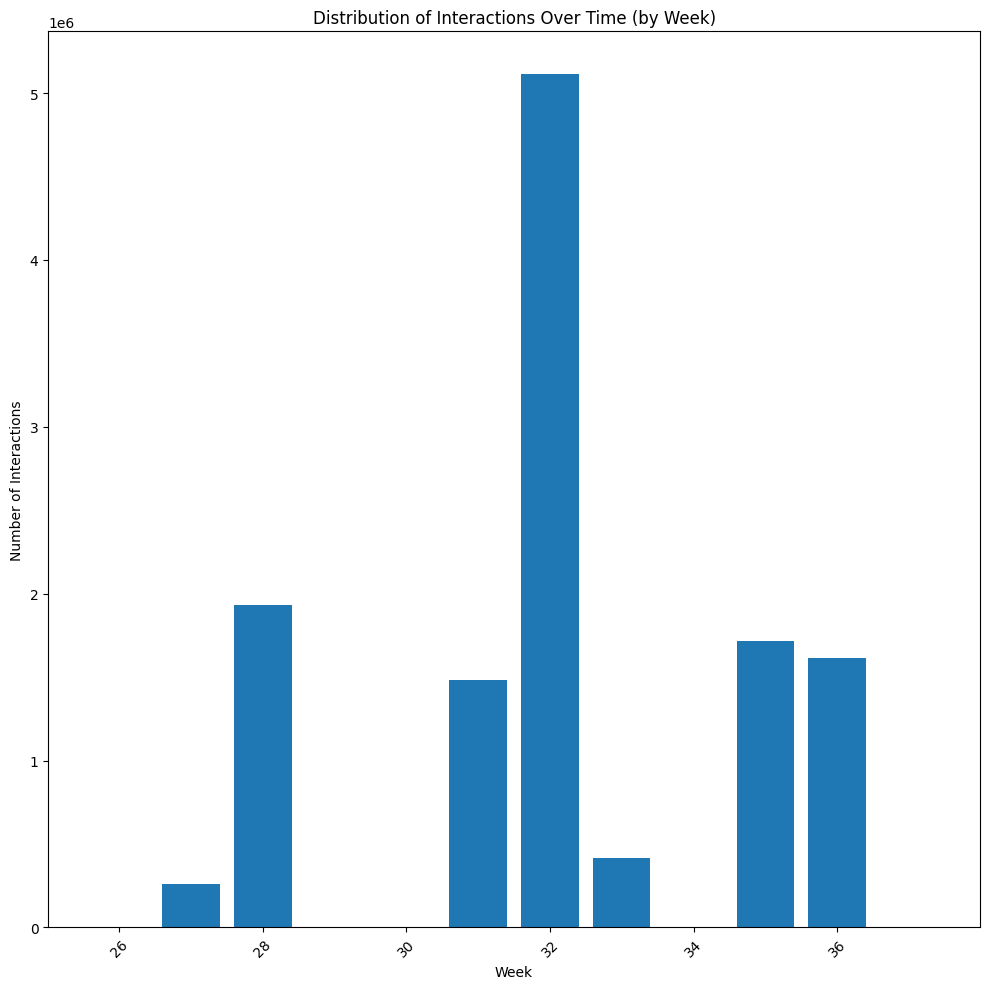

In [ ]:
print(f'Minimun timestamp :{big.timestamp.min()}')
print(f'Maximum timestamp :{big.timestamp.max()}')

# Get the distribution of interactions over the time, counting per week
big['week'] = big['timestamp'].dt.isocalendar().week
interaction_distribution_week = big.groupby('week').size().reset_index(name='counts')
interaction_distribution_week = interaction_distribution_week.sort_values(by='week')

plt.figure(figsize=(10, 6))
plt.bar(interaction_distribution_week['week'], interaction_distribution_week['counts'])
plt.xlabel('Week')
plt.ylabel('Number of Interactions')
plt.title('Distribution of Interactions Over Time (by Week)')
plt.xticks(rotation=45)
plt.tight_layout()


Some data is missing for some weeks, we should be careful if we use the date as a feature. We should for example not only consider the videos the user watch the week before because in some case we don't have any data.

The minimum range is of 3 weeks (for example we are week 31 and we want to predict videos at that moment, we should at least looks for interaction from week 28 to 31)

### Now for the other datasets the objective is to get features that describe correctly our videos


## Item_daily_features

The following give a short desciption of all the columns of this dataset. The objective is to find some informations that we could consider as a feature describing our video



📹 Video Metadata

   video_id: Unique identifier for the video.

   date: Date of the statistics in YYYYMMDD format.

   author_id: Identifier of the video's author.

   video_type: Type of the video, e.g., "NORMAL" or "AD".

   upload_dt: Date when the video was uploaded (YYYY-MM-DD).

   upload_type: Method of upload, e.g., "ShortImport", "LongImport", or "ShortCamera".

   visible_status: Visibility status of the video, such as "public".

   video_duration: Duration of the video in milliseconds.

   video_width: Width of the video in pixels.

   video_height: Height of the video in pixels.

   music_id: Identifier for the background music used in the video.

   video_tag_id: Identifier for the video's tag.

   video_tag_name: Name of the tag associated with the video.
   KuaiSAR+1ar5iv+1
   KuaiSAR+2GitHub+2KuaiRec+2

👁️ Exposure and Playback Metrics

   show_cnt: Number of times the video was shown to users on that day.

   show_user_num: Number of unique users who were shown the video.

   play_cnt: Total number of times the video was played.

   play_user_num: Number of unique users who played the video.

   play_duration: Total time (in milliseconds) the video was played.

   complete_play_cnt: Number of times the video was played to completion.

   complete_play_user_num: Number of unique users who played the video to completion.

   valid_play_cnt: Number of valid plays based on duration thresholds.

   valid_play_user_num: Number of unique users with valid plays.

   long_time_play_cnt: Number of long-duration plays based on specific criteria.

   long_time_play_user_num: Number of unique users with long-duration plays.

   short_time_play_cnt: Number of short-duration plays.

   short_time_play_user_num: Number of unique users with short-duration plays.

   play_progress: Average play progress ratio, calculated as play_duration / video_duration.
   GitHub+1KuaiRec+1

💬 Engagement Metrics

   comment_stay_duration: Total time users spent in the comments section.

   like_cnt: Total number of likes the video received.

   like_user_num: Number of unique users who liked the video.

   click_like_cnt: Number of likes resulting from double-clicks.

   double_click_cnt: Number of double-click interactions on the video.

   cancel_like_cnt: Number of likes that were canceled.

   cancel_like_user_num: Number of unique users who canceled their likes.

   comment_cnt: Total number of comments made on the video.

   comment_user_num: Number of unique users who commented.

   direct_comment_cnt: Number of direct (top-level) comments.

   reply_comment_cnt: Number of reply (nested) comments.

   delete_comment_cnt: Number of comments that were deleted.

   delete_comment_user_num: Number of unique users who deleted their comments.

   comment_like_cnt: Number of likes on comments.

   comment_like_user_num: Number of unique users who liked comments.
   GitHub

👥 Social Interaction Metrics

   follow_cnt: Number of new follows generated from the video.

   follow_user_num: Number of unique users who followed the author due to the video.

   cancel_follow_cnt: Number of unfollows resulting from the video.

   cancel_follow_user_num: Number of unique users who unfollowed the author due to the video.
   GitHub

📤 Sharing and Feedback Metrics

   share_cnt: Number of times the video was shared.

   share_user_num: Number of unique users who shared the video.

   download_cnt: Number of times the video was downloaded.

   download_user_num: Number of unique users who downloaded the video.

   report_cnt: Number of times the video was reported.

   report_user_num: Number of unique users who reported the video.

   reduce_similar_cnt: Number of times users chose to reduce similar content.

   reduce_similar_user_num: Number of unique users who opted to reduce similar content.

   collect_cnt: Number of times the video was added to favorites.

   collect_user_num: Number of unique users who added the video to favorites.

   cancel_collect_cnt: Number of times the video was removed from favorites.

   cancel_collect_user_num: Number of unique users who removed the video from favorites.

In [ ]:
# Data analysis of item_daily_features


## Categories

In [20]:
categories

,video_id,feat
0,0,[8]
1,1,"[27, 9]"
2,2,[9]
3,3,[26]
4,4,[5]
...,...,...
10723,10723,[11]
10724,10724,[2]
10725,10725,[15]
10726,10726,[19]


The categories dataset designates the categories of each video.

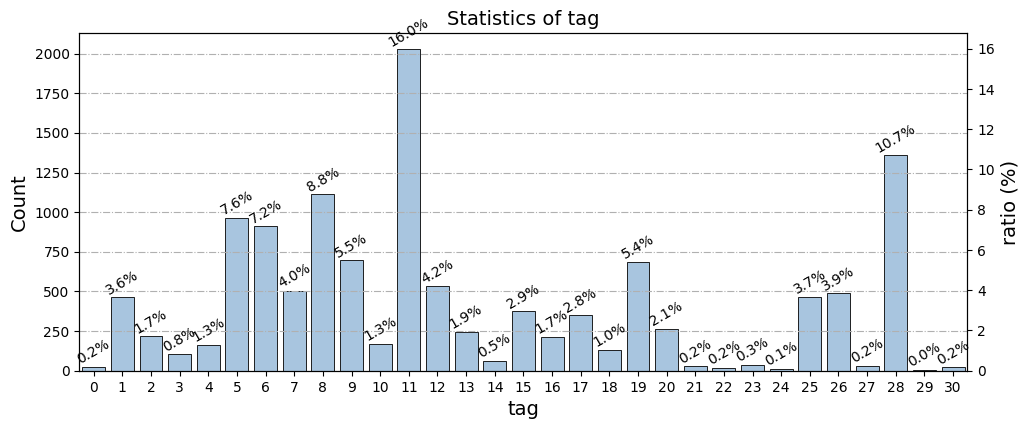

In [6]:
def visual_statistics_discrete(df, var="my_variable", display_ratio=True, func=None, order=None, size=(6, 4.5)):
    ncount = len(df)

    fig = plt.figure(figsize=size)
    ax1 = fig.add_axes([0.14, 0.15, 0.74, 0.75])
    sns.countplot(x=df, color="#9fc5e8", linewidth=.6, edgecolor='k', ax=ax1, order=order)


    plt.grid(axis='y', linestyle='-.')

    gca = plt.gca()
    fig_title = "Statistics of {}".format(var)
    gca.set_title(fig_title, fontsize=14)
    gca.set_ylabel("Count", fontsize=14)
    gca.set_xlabel(var, fontsize=14)
    
    if func:
        func(ax1)

    if display_ratio:
        # Make twin axis
        ax2 = ax1.twinx()
        ax2.set_ylabel("ratio (%)", fontsize=14)


        for p in ax1.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax1.annotate('{:.1f}%'.format(100. * y / ncount), (x.mean(), y),
                         ha='center', va='bottom', fontsize=10, rotation=30)  # set the alignment of the text

        ax2.set_ylim(0, ax1.get_ylim()[1] / ncount * 100)

    plt.show()

temp = categories.copy()
temp["feat"] = temp["feat"].map(eval)
cnt = temp.feat.map(collections.Counter)
cnt_all = collections.Counter()
for d in cnt:
    cnt_all.update(d)
# print(dict(cnt_all))
all_feat = pd.Series(sorted(list(itertools.chain.from_iterable([[i]*k for i,k in cnt_all.items()]))),name="feat")
# print(all_feat)
visual_statistics_discrete(all_feat, "tag", size=(12,4.5))


The categories seems like an intersting feature, with 31 different tag of categories.

## Kuairec caption

In [66]:
print(caption.dtypes)
caption.head()

video_id                        int64
manual_cover_text              object
caption                        object
topic_tag                      object
first_level_category_id       float64
first_level_category_name      object
second_level_category_id      float64
second_level_category_name     object
third_level_category_id       float64
third_level_category_name      object
dtype: object


,video_id,manual_cover_text,caption,topic_tag,first_level_category_id,first_level_category_name,second_level_category_id,second_level_category_name,third_level_category_id,third_level_category_name
0,0,UNKNOWN,精神小伙路难走 程哥你狗粮慢点撒,[],8.0,颜值,673.0,颜值随拍,-124.0,UNKNOWN
1,1,UNKNOWN,,[],27.0,高新数码,-124.0,UNKNOWN,-124.0,UNKNOWN
2,2,UNKNOWN,晚饭后，运动一下！,[],9.0,喜剧,727.0,搞笑互动,-124.0,UNKNOWN
3,3,UNKNOWN,我平淡无奇，惊艳不了时光，温柔不了岁月，我只想漫无目的的走走，努力发笔小财，给自己买花 自己长大.,[],26.0,摄影,686.0,主题摄影,2434.0,景物摄影
4,4,五爱街最美美女 一天1q,#搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,"[五爱市场,感谢快手我要上热门,搞笑]",5.0,时尚,737.0,营销售卖,2596.0,女装


We don't care about the ids since we have the text corresponding to it

In [68]:
caption.drop(columns=['first_level_category_id', 'second_level_category_id', 'third_level_category_id'], inplace=True)

There are also a lot of 'UNKNOW', if i want to apply a tfidf on all the text in this dataset i shouldn't take into account the unknow

[(' ', 29922), ('#', 19477), ('手', 7294), ('，', 6710), ('0', 6533), ('快', 6352), ('的', 5283), ('热', 4411), ('我', 4166), ('门', 3919)]


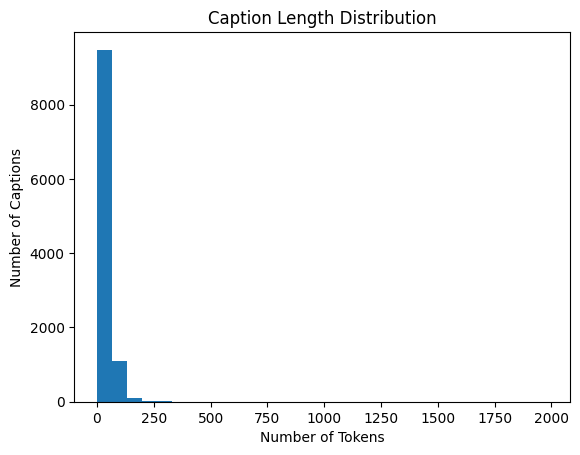

In [69]:
# Flatten all tokens into a single list
all_tokens = [token for caption in caption['caption'] for token in caption]

# Count token frequencies
token_counts = Counter(all_tokens)

# Display the 10 most common tokens
print(token_counts.most_common(10))

# Plot caption length distribution
caption_lengths = caption['caption'].apply(len)
plt.hist(caption_lengths, bins=30)
plt.title("Caption Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Captions")
plt.show()

The text of this dataset is only chinese character 

# **2) Feature Engineering**

Convert all the video_id in the same type because if i merge table it will be on the video id

In [33]:
# video represent by their caption
caption['video_id'] = caption['video_id'].astype(str)
# drop all rows with video_ids that are not digits
caption = caption[caption['video_id'].str.isdigit()]
# convert video_id to int64
caption['video_id'] = caption['video_id'].astype(np.int64)
categories['video_id'] = categories['video_id'].astype(np.int64)
item_daily_features['video_id'] = item_daily_features['video_id'].astype(np.int64)

### 1) Represent videos by their metadata

Since we are using cosine similarity all our feature must be numerical.

In [113]:
# Get all the possible values stock in the column visible_status
print(item_daily_features.video_type.unique())
print(item_daily_features['visible_status'].unique())

['NORMAL' 'AD']
['public' 'private' 'only friends']


Here are the data from the metadata part of the dataset item_daily_features i decided to take to represents my videos:
- author_id -> create a column for each author_id
- video_type -> transform the 2 strings contain inside to a binary value
- visible_status -> create one column by status
- video_duration -> using the analysis of distribution in data analysis create 10 category of range of time
- video_height
- video_width

To test my selection of features with my model i'll split this representation into 3 different df. 

The first one with the videos only represented by their video_duration, video_type and video_status.

The second one is like the first one with the author_id in addition

The last one is everything listed above

In [54]:
# videos represent by their metadata
video_metadata = item_daily_features[['video_id', 'author_id', 'video_type', 'visible_status', 'video_duration', 'video_width', 'video_height']]
video_metadata = video_metadata.drop_duplicates(subset=['video_id'])

# Convert video type to int meaning if it is AD it is 0 and if it is NORMAL 1
video_metadata['video_type'] = video_metadata['video_type'].apply(lambda x: 1 if x == 'NORMAL' else 0)
# Create one category per video type
video_metadata['public'] = 0
video_metadata['private'] = 0
video_metadata['only_friends'] = 0
video_metadata['public'] = video_metadata['visible_status'].apply(lambda x: 1 if x == 'public' else 0)
video_metadata['private'] = video_metadata['visible_status'].apply(lambda x: 1 if x == 'private' else 0)
video_metadata['only_friends'] = video_metadata['visible_status'].apply(lambda x: 1 if x == 'only friends' else 0)
video_metadata.drop(columns=['visible_status'], inplace=True)
video_metadata.dropna(inplace=True)
video_metadata.reset_index(drop=True, inplace=True)

# Using the range split we got in the data analysis
# We can create a category for each range of video_duration
time_range = {0: (0.0223, 1.011), 1: (1.011, 1.172), 2: (1.172, 1.316), 3: (1.316, 1.467), 4: (1.467, 1.606), 5: (1.606, 1.756), 6: (1.756, 1.922), 7: (1.922, 2.266), 8: (2.266, 4.04), 9: (4.04, 52.512)}
for i in time_range.keys():
    video_metadata[f'time_category_{i}'] = 0
for i in time_range.keys():
    video_metadata.loc[(video_metadata['video_duration'] >= time_range[i][0]) & (video_metadata['video_duration'] < time_range[i][1]), f'time_category_{i}'] = 1
video_metadata.drop(columns=['video_duration'], inplace=True)
video_metadata_1 = video_metadata.copy()
video_metadata_1.drop(columns=['author_id', 'video_width', 'video_height'], inplace=True)
print(video_metadata_1.head(3))
print("----------------------")

for id in video_metadata['author_id'].unique():
    video_metadata[f'author_id_{id}'] = 0
for i in video_metadata['author_id'].unique():
    video_metadata.loc[video_metadata['author_id'] == i, f'author_id_{i}'] = 1
video_metadata.drop(columns=['author_id'], inplace=True)
video_metadata_2 = video_metadata.copy()
video_metadata_2.drop(columns=['video_width', 'video_height'], inplace=True)
print(video_metadata_2.head(3))
print("----------------------")

video_metadata_3 = video_metadata
print(video_metadata_3.head(3))

   video_id  video_type  public  private  only_friends  time_category_0  \
0         0           1       1        0             0                0   
1         2           1       1        0             0                0   
2         4           1       1        0             0                0   

   time_category_1  time_category_2  time_category_3  time_category_4  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   

   time_category_5  time_category_6  time_category_7  time_category_8  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   

   time_category_9  
0                0  
1                0  
2                0  
----------------------


/tmp/ipykernel_154378/1671452730.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  video_metadata[f'author_id_{id}'] = 0
/tmp/ipykernel_154378/1671452730.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  video_metadata[f'author_id_{id}'] = 0
/tmp/ipykernel_154378/1671452730.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

   video_id  video_type  public  private  only_friends  time_category_0  \
0         0           1       1        0             0                0   
1         2           1       1        0             0                0   
2         4           1       1        0             0                0   

   time_category_1  time_category_2  time_category_3  time_category_4  ...  \
0                0                0                0                0  ...   
1                0                0                0                0  ...   
2                0                0                0                0  ...   

   author_id_1728  author_id_8246  author_id_7009  author_id_6648  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   

   author_id_5241  author_id_1449  author_id_3276  author_id_236  \
0               0               0        

In [51]:
common_video_ids = set(caption['video_id']).intersection(set(categories['video_id']))
common_video_ids = set(common_video_ids).intersection(set(video_metadata['video_id']))
# print(len(common_video_ids)drop)
common_video_ids = list(common_video_ids)
# Get datatypes of the items in common_video_ids

### 2) Represents the video by their exposure and engagement metrics

I decided that the features i wanted to explore was the following:
- play_cnt
- show_cnt
- play_duration
- complete_play_cnt
- valid_play_cnt
- like_cnt
- comment_stay_duration

I have two way to use as a representation of my videos:

*Approach 1*:
- Do the sum of all the selected values for the complete range of datetime where we have data

*Approach 2*:
- Once the sum done exctract some key values by doing some computations

#### Approach 1

In [10]:
# video represents by their stats
videos_stats_intersting = item_daily_features[['video_id', 'play_cnt', 'show_cnt', 'play_duration', 'complete_play_cnt', 'valid_play_cnt', 'like_cnt', 'comment_stay_duration']]
# videos_stats_intersting = videos_stats_intersting[videos_stats_intersting['video_id'].isin(common_video_ids)]
videos_stats_intersting
videos_stats = videos_stats_intersting.groupby('video_id').agg({
    'play_cnt': 'sum',
    'show_cnt': 'sum',
    'play_duration': 'sum',
    'complete_play_cnt': 'sum',
    'valid_play_cnt': 'sum',
    'like_cnt': 'sum',
    'comment_stay_duration': 'sum'
}).reset_index()
videos_stats_1 = videos_stats.copy()
videos_stats_1

,video_id,play_cnt,show_cnt,play_duration,complete_play_cnt,valid_play_cnt,like_cnt,comment_stay_duration
0,0,411691,805839,3672586209,231018,224751,24493,435345336
1,1,141667,136718,2453652741,42582,77368,8267,104517748
2,2,670248,650377,8644331149,453815,474834,3180,25088506
3,3,9137,16406,79212221,815,3966,941,1942410
4,4,610,825,7506745,186,280,3,308977
...,...,...,...,...,...,...,...,...
10723,10723,214,277,1681908,117,114,24,337534
10724,10724,965,1100,56090732,535,754,264,1249884
10725,10725,15487,16996,323787284,8149,9317,851,1963153
10726,10726,7859,7644,128835301,5480,5382,44,192695


#### Approach 2

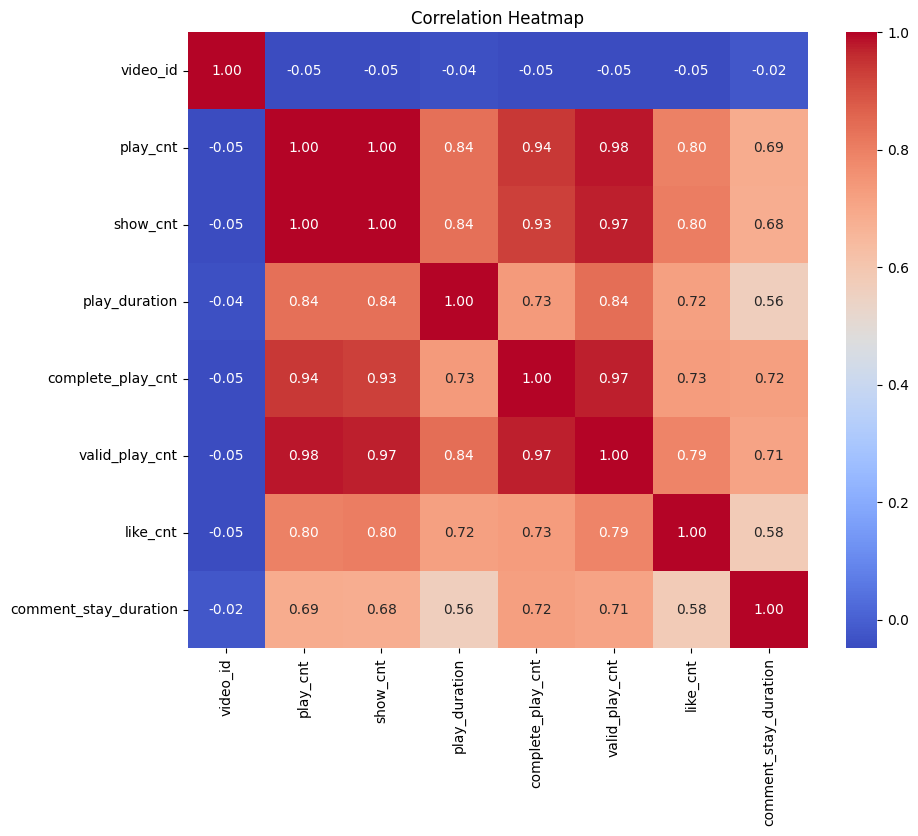

In [122]:
correlation_matrix = videos_stats.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

With the correlation heatmap we can see that we have redundant information:
- play_cnt and show_cnt carries similar informations
- complete_play_cnt and valid_play_cnt carries similar informations

In fact play_cnt, show_cnt, complete_play_cnt and valid_play_cnt carries similar informations

Therefore i'll only keep valid_play_cnt

I'll create a score *interesting* to see if the user has tendancy to click to watch the video when proposed. If we take youtube as an example *intersting* is a score that evaluates your thumbnail

I'll create a *ratio play comment* to evaluate if it is a video that tends to be watched or is it a video where people are only interest by the comments. If we take instagram reals as an example is like determining if the real is to be watched or it is a real of the style *watch in the comment*

I'll create a score *like*, it is a ratio to evaluate if the video is like or not in average

In [11]:
# Drop redundant columns
videos_stats.drop(columns=['play_cnt', 'complete_play_cnt'], inplace=True)

# Create score intersting
videos_stats['intersting'] = videos_stats['valid_play_cnt'] / (videos_stats['show_cnt'] + 1)
videos_stats['intersting'] = videos_stats['intersting'].apply(lambda x: round(x, 2))

# Converts the duration from milliseconds to minutes
videos_stats['comment_stay_duration'] = videos_stats['comment_stay_duration'] / 6000
videos_stats['play_duration'] = videos_stats['play_duration'] / 6000

# videos_stats['average_comment_stay'] = videos_stats['comment_stay_duration'] / (videos_stats['valid_play_cnt'] + 1)
# videos_stats['average_comment_stay'] = videos_stats['average_comment_stay'].apply(lambda x: round(x, 2))
videos_stats['ratio_play_comment'] = videos_stats['play_duration'] / (videos_stats['comment_stay_duration'] + 1)
videos_stats['ratio_play_comment'] = videos_stats['ratio_play_comment'].apply(lambda x: round(x, 2))

# Create score liked 
videos_stats['liked'] = videos_stats['like_cnt'] / (videos_stats['valid_play_cnt'] + 1)
videos_stats['liked'] = videos_stats['liked'].apply(lambda x: round(x, 2))

# Drop unnecessary columns
videos_stats.drop(columns=['show_cnt', 'play_duration', 'valid_play_cnt', 'like_cnt', 'comment_stay_duration'], inplace=True)
videos_stats.dropna(inplace=True)
videos_stats_2 = videos_stats
videos_stats_2

,video_id,intersting,ratio_play_comment,liked
0,0,0.28,8.44,0.11
1,1,0.57,23.47,0.11
2,2,0.73,344.47,0.01
3,3,0.24,40.65,0.24
4,4,0.34,23.83,0.01
...,...,...,...,...
10723,10723,0.41,4.90,0.21
10724,10724,0.68,44.66,0.35
10725,10725,0.55,164.43,0.09
10726,10726,0.70,648.41,0.01


### 3) Represent the videos by their categories

The idea is just one hot encode our categories

In [8]:
# videos represent by their categories
# categories = categories[categories['video_id'].isin(common_video_ids)]
for i in range (31):
    categories['category_' + str(i)] = 0

categories['feat'] = categories['feat'].apply(ast.literal_eval)
for index, row in categories.iterrows():
    # Get the list of features for the current row
    features = row['feat']

    # Set the corresponding category columns to 1
    for feat in features:
        col_name = f'category_{feat}'
        if col_name in categories.columns:
            categories.at[index, col_name] = 1
categories.drop(columns=['feat'], inplace=True)
categories

,video_id,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,...,category_21,category_22,category_23,category_24,category_25,category_26,category_27,category_28,category_29,category_30
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10723,10723,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10724,10724,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10725,10725,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10726,10726,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4) Represent the videos by their captions

The idea is to convert the value that are string in the captions dataset into numerical value. To do that we are going to concatenate all the string then used tfidf on it

In [19]:
# caption = caption[caption['video_id'].isin(common_video_ids)]

def combine_text_fields(row):
    fields = [
        row['manual_cover_text'],
        row['caption'],
        row['topic_tag'],
        row['first_level_category_name'],
        row['second_level_category_name'],
        row['third_level_category_name']
    ]
    return ' '.join([str(f) for f in fields if f and f != 'UNKNOWN' and f != '[]'])

caption['text'] = caption.apply(combine_text_fields, axis=1)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(caption['text'])
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 68465 stored elements and shape (10732, 29481)>

# **3) Model**

I am using cosine similarity on my vector of videos features to recommend similar content

For example if i only use my categories representation of my videos it will be something like:

In [ ]:
cosine_sim_categories = cosine_similarity(categories.iloc[:, 1:])

The idea is to test for all my different representation of my videos then merge the intresting features together

# **4) Recommender Algorithm**

The goal is to be able to recommend videos to a user.

The **first step** is to understand what is the profil of the user (what does he likes), so that i can give in input to my **cosine similarity** matrix the videos that my user likes to recommend similar kind of videos.

We have to determine relevant videos that describes my user. To do so I use the watch_ratio as a score, if a video has a watch_ratio greather than a threshold I'll consider it as a relevant video to describe my user.

To have an even more accurate profil of my user I also use datetime information. Meaning that if I want to recommend video at a time *T*, I'll give more importance to the video he watched recently. 

To do so my threshold of watch_ratio will get higher and higher over time.


Once the profil of the user done, we can than use our **cosine similarity** matrix to compute the similarity of all the videos with the videos liked by our user.

Then we select the top N videos with the best similarity score

In [23]:
def generate_top_n_recommendations_from_logs(interactions_df, cosine_sim, video_ids, N=10, min_watch_ratio=(0.6, 0.75, 0.9), date='2020-09-05'):
    """
    Generate top-N recommendations based on user-video interactions and cosine similarity.
    """
    # Filter for meaningful interactions
    date = pd.to_datetime(date)
    # For every video watch in the time range [date - 7 days, date]
    # interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'], unit='s')
    week_before_df = interactions_df[(interactions_df['timestamp'] >= date - pd.Timedelta(days=7)) & (interactions_df['timestamp'] <= date)]
    week_2_before_df = interactions_df[(interactions_df['timestamp'] >= date - pd.Timedelta(days=14)) & (interactions_df['timestamp'] < date - pd.Timedelta(days=7))]
    month_before_df = interactions_df[(interactions_df['timestamp'] >= date - pd.Timedelta(days=30)) & (interactions_df['timestamp'] < date - pd.Timedelta(days=14))]

    min_ratio_w1, min_ratio_w1, min_ratio_m = min_watch_ratio
    filtered_w1 = week_before_df[week_before_df['watch_ratio'] >= min_ratio_w1]
    filtered_w2 = week_2_before_df[week_2_before_df['watch_ratio'] >= min_ratio_w1]
    filtered_m = month_before_df[month_before_df['watch_ratio'] >= min_ratio_m]
    filtered = pd.concat([filtered_w1, filtered_w2, filtered_m])

    # Build user -> set of watched video_ids
    user_histories = filtered.groupby('user_id')['video_id'].apply(set).to_dict()

    recommendations = {}

    for user, watched in user_histories.items():
        # print(user, watched)
        watched_indices = [video_ids.get_loc(v) for v in watched if v in video_ids]
        if not watched_indices:
            recommendations[user] = []
            continue

        # Sum similarities of all watched videos
        sim_scores = np.sum(cosine_sim[watched_indices], axis=0)

        # Set similarity of already watched videos to -1
        for v in watched:
            if v in video_ids:
                sim_scores[video_ids.get_loc(v)] = -1

        top_indices = np.argsort(sim_scores)[::-1][:N]
        top_videos = video_ids[top_indices].tolist()
        recommendations[user] = top_videos

    return recommendations

def generate_top_n_recommendations_from_logs_sp(interactions_df, cosine_sim, video_ids, N=10, min_watch_ratio=0.5):
    """
    Generate top-N recommendations based on user-video interactions and cosine similarity.
    """
    # Filter for meaningful interactions
    filtered = interactions_df[interactions_df['watch_ratio'] >= min_watch_ratio]

    # Build user -> set of watched video_ids
    user_histories = filtered.groupby('user_id')['video_id'].apply(set).to_dict()

    recommendations = {}

    for user, watched in user_histories.items():
        # print(user, watched)
        watched_indices = [video_ids.get_loc(v) for v in watched if v in video_ids]
        if not watched_indices:
            recommendations[user] = []
            continue

        # Sum similarities of all watched videos
        sim_scores = np.array(np.sum(cosine_sim[watched_indices], axis=0)).ravel()

        # Set similarity of already watched videos to -1
        for v in watched:
            if v in video_ids:
                sim_scores[video_ids.get_loc(v)] = -1

        top_indices = np.argsort(sim_scores)[::-1][:N]
        top_videos = video_ids[top_indices].tolist()
        recommendations[user] = top_videos

    return recommendations

# 5) Evaluate the model

In [24]:
def prepare_test_ground_truth(interactions_df, min_watch_ratio=0.7):
    """
    Return user -> set of relevant video_ids from test interactions.
    """
    filtered = interactions_df[interactions_df['watch_ratio'] >= min_watch_ratio]
    return filtered.groupby('user_id')['video_id'].apply(set).to_dict()

In [ ]:
common_video_ids = set(caption['video_id']).intersection(set(categories['video_id']))
common_video_ids = set(common_video_ids).intersection(set(video_metadata_3['video_id']))
common_video_ids = set(common_video_ids).intersection(set(video_metadata_2['video_id']))
common_video_ids = set(common_video_ids).intersection(set(video_metadata_1['video_id']))
common_video_ids = set(common_video_ids).intersection(set(videos_stats_2['video_id']))
common_video_ids = list(common_video_ids)

10438


In [ ]:
train_df, test_df = big, small
video_ids_train = pd.Index(train_df['video_id'].unique())
common_video_ids = set(caption['video_id']).intersection(set(categories['video_id']))
common_video_ids = set(common_video_ids).intersection(set(video_metadata_3['video_id']))
common_video_ids = set(common_video_ids).intersection(set(videos_stats_2['video_id']))
common_video_ids = list(common_video_ids)
# Only keep video_ids that are in caption, metadata and categories
videos_ids_train = video_ids_train.isin(common_video_ids)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [ ]:
def precision_at_k_log(recommendations, test_ground_truth, k=10):
    precisions = []
    for user, recs in recommendations.items():
        true_items = test_ground_truth.get(user, set())
        if not true_items:
            continue
        hits = len(set(recs[:k]) & true_items)
        precisions.append(hits / k)
    return np.mean(precisions) if precisions else 0

def ndcg_at_k_log(recommendations, test_ground_truth, k=10):
    ndcgs = []
    for user, recs in recommendations.items():
        true_items = test_ground_truth.get(user, set())
        if not true_items:
            continue
        y_true = [1 if vid in true_items else 0 for vid in recs[:k]]
        y_score = list(range(k, 0, -1))
        ndcgs.append(ndcg_score([y_true], [y_score]))
    return np.mean(ndcgs) if ndcgs else 0

def mrr_log(recommendations, test_ground_truth):
    rr = []
    for user, recs in recommendations.items():
        true_items = test_ground_truth.get(user, set())
        if not true_items:
            continue
        for rank, vid in enumerate(recs, 1):
            if vid in true_items:
                rr.append(1 / rank)
                break
        else:
            rr.append(0)
    return np.mean(rr) if rr else 0

def serendipity_log(recommendations, train_ground_truth, cosine_sim, video_ids, k=10):
    serendipities = []
    for user, recs in recommendations.items():
        watched = train_ground_truth.get(user, set())
        if not watched:
            continue
        rec_indices = [video_ids.get_loc(v) for v in recs[:k] if v in video_ids]
        watched_indices = [video_ids.get_loc(v) for v in watched if v in video_ids]
        if not rec_indices or not watched_indices:
            continue
        avg_sim = np.mean([cosine_sim[i, j] for i in watched_indices for j in rec_indices])
        serendipities.append(1 - avg_sim)
    return np.mean(serendipities) if serendipities else 0

In [48]:
cosine_sim_caption = cosine_similarity(tfidf_matrix, tfidf_matrix)

N = 50
recs_train_caption = generate_top_n_recommendations_from_logs(
    interactions_df=train_df,
    cosine_sim=cosine_sim_caption,
    video_ids=video_ids_train,
    N=N,
    min_watch_ratio=(0.7, 0.85, 1.0),
    date='2020-09-05'
)

test_truth = prepare_test_ground_truth(
    interactions_df=test_df,
    min_watch_ratio=0.6
)

prec  = precision_at_k_log(recs_train_caption, test_truth, k=N)
ndcg = ndcg_at_k_log(recs_train_caption, test_truth, k=N)
mrr = mrr_log(recs_train_caption, test_truth)
serendipity = serendipity_log(recs_train_caption, test_truth, cosine_sim_caption, video_ids_train, k=N)
print(f"Precision@{N} for caption sim: {prec:.4f}")
print(f"NDCG@{N} for caption sim: {ndcg:.4f}")
print(f"MRR@{N} for caption sim: {mrr:.4f}")
print(f"Serendipity@{N} for caption sim: {serendipity:.4f}")

Precision@50 for caption sim: 0.1906
NDCG@50 for caption sim: 0.5469
MRR@50 for caption sim: 0.3768
Serendipity@50 for caption sim: 0.9795


**VIDEO FEATURES = CAPTION**

train watch_ratio = (0.6, 0.75, 0.9) and evaluate with watch_ratio = 0.6
| Precision@10 | NDCG@10 | MRR@10 | Serendipity@10 |
| ------------ | ------- | ------ | -------------- |
| 0.1790       | 0.4723  | 0.3626 | 0.9760         |

train watch_ratio = (0.7, 0.85, 1.0) and evaluate with watch_ratio = 0.6
| Precision@10 | NDCG@10 | MRR@10 | Serendipity@10 |
| ------------ | ------- | ------ | -------------- |
| 0.1890       | 0.4834  | 0.3684 | 0.9771         |

--------------------------------------------------------------------------

train watch_ratio = (0.6, 0.75, 0.9) and evaluate with watch_ratio = 0.6
| Precision@25 | NDCG@25 | MRR@25 | Serendipity@25 |
| ------------ | ------- | ------ | -------------- |
| 0.1910       | 0.5168  | 0.3719 | 0.9780         |

--------------------------------------------------------------------------

train watch_ratio = (0.6, 0.75, 0.9) and evaluate with watch_ratio = 0.6
| Precision@50 | NDCG@50 | MRR@50 | Serendipity@50 |
| ------------ | ------- | ------ | -------------- |
| 0.1928       |  0.5433 | 0.3723 | 0.9789         |


In [49]:
cosine_sim_category = cosine_similarity(categories.iloc[:, 1:])

N = 50
recs_train_category = generate_top_n_recommendations_from_logs(
    interactions_df=train_df,
    cosine_sim=cosine_sim_category,
    video_ids=video_ids_train,
    N=N,
    min_watch_ratio=(0.7, 0.85, 1.0),
    date='2020-09-05'
)

test_truth = prepare_test_ground_truth(
    interactions_df=test_df,
    min_watch_ratio=0.6
)

prec  = precision_at_k_log(recs_train_category, test_truth, k=N)
ndcg = ndcg_at_k_log(recs_train_category, test_truth, k=N)
mrr = mrr_log(recs_train_category, test_truth)
serendipity = serendipity_log(recs_train_category, test_truth, cosine_sim_category, video_ids_train, k=N)
print(f"Precision@{N} for category sim: {prec:.4f}")
print(f"NDCG@{N} for category sim: {ndcg:.4f}")
print(f"MRR@{N} for category sim: {mrr:.4f}")
print(f"Serendipity@{N} for category sim: {serendipity:.4f}")

Precision@50 for category sim: 0.2108
NDCG@50 for category sim: 0.6459
MRR@50 for category sim: 0.5606
Serendipity@50 for category sim: 0.8040


**VIDEO FEATURES = CATEGORY**

train watch_ratio = (0.6, 0.75, 0.9) and evaluate with watch_ratio = 0.6
| Precision@10 | NDCG@10 | MRR@10 | Serendipity@10 |
| ------------ | ------- | ------ | -------------- |
| 0.3118       | 0.6710  | 0.5960 | 0.8006         |

train watch_ratio = (0.7, 0.85, 1.0) and evaluate with watch_ratio = 0.6
| Precision@10 | NDCG@10 | MRR@10 | Serendipity@10 |
| ------------ | ------- | ------ | -------------- |
| 0.2972       | 0.6474  | 0.5564 | 0.8018         |

--------------------------------------------------------------------------

train watch_ratio = (0.6, 0.75, 0.9) and evaluate with watch_ratio = 0.6
| Precision@25 | NDCG@25 | MRR@25 | Serendipity@25 |
| ------------ | ------- | ------ | -------------- |
| 0.2654       | 0.6692  | 0.5830 | 0.8109         |

--------------------------------------------------------------------------

train watch_ratio = (0.6, 0.75, 0.9) and evaluate with watch_ratio = 0.6
| Precision@50 | NDCG@50 | MRR@50 | Serendipity@50 |
| ------------ | ------- | ------ | -------------- |
| 0.2340       | 0.6650  | 0.5831 | 0.8103         |


In [ ]:
cosine_sim_metadata_1 = cosine_similarity(video_metadata_1.iloc[:, 1:])
cosine_sim_metadata_2 = cosine_similarity(video_metadata_2.iloc[:, 1:])
cosine_sim_metadata_3 = cosine_similarity(video_metadata_3.iloc[:, 1:])

N = 10
recs_train_metadata = generate_top_n_recommendations_from_logs(
    interactions_df=train_df,
    cosine_sim=cosine_sim_metadata_1,
    video_ids=video_ids_train,
    N=N,
    min_watch_ratio=(0.6, 0.75, 0.9),
    date='2020-09-05'
)

test_truth = prepare_test_ground_truth(
    interactions_df=test_df,
    min_watch_ratio=0.6
)

prec  = precision_at_k_log(recs_train_metadata, test_truth, k=N)
ndcg = ndcg_at_k_log(recs_train_metadata, test_truth, k=N)
mrr = mrr_log(recs_train_metadata, test_truth)
serendipity = serendipity_log(recs_train_metadata, test_truth, cosine_sim_metadata_1, video_ids_train, k=N)
print(f"Precision@{N} for metadata sim: {prec:.4f}")
print(f"NDCG@{N} for metadata sim: {ndcg:.4f}")
print(f"MRR@{N} for metadata sim: {mrr:.4f}")
print(f"Serendipity@{N} for metadata sim: {serendipity:.4f}")

Hit Rate@10 for metadata sim: 0.0017
Precision@10 for metadata sim: 0.2893
NDCG@10 for metadata sim: 0.5474
MRR@10 for metadata sim: 0.4775
Serendipity@10 for metadata sim: 0.0024

In [ ]:
# Merge metadata + categories (both as DataFrames)
video_features = pd.merge(categories, video_metadata, on='video_id', how='inner')
# Drop video_id temporarily
video_ids = video_features['video_id'].values
video_features_no_id = video_features.drop(columns=['video_id'])

# Scale metadata numerics
scaler = StandardScaler()
dense_features_scaled = scaler.fit_transform(video_features_no_id)

id_pos = caption['video_id'].reset_index(drop=True)
indices = [id_pos[id_pos == vid].index[0] for vid in video_ids]
tfidf_aligned = tfidf_matrix[indices]

dense_sparse = csr_matrix(dense_features_scaled)  # convert dense to sparse
combined_matrix = hstack([dense_sparse * 2.00, tfidf_aligned * 1.00])  # sparse + sparse = sparse

In [ ]:
cosine_sim_merged = cosine_similarity(combined_matrix, dense_output=False)  # still sparse

N = 10
recs_train_merged = generate_top_n_recommendations_from_logs(
    interactions_df=train_df,
    cosine_sim=cosine_sim_merged,
    video_ids=video_ids_train,
    N=N,
    min_watch_ratio=0.75
)

test_truth = prepare_test_ground_truth(
    interactions_df=test_df,
    min_watch_ratio=0.75
)

prec  = precision_at_k_log(recs_train_merged, test_truth, k=N)
ndcg = ndcg_at_k_log(recs_train_merged, test_truth, k=N)
mrr = mrr_log(recs_train_merged, test_truth)
# serendipity = serendipity_log(recs_train_caption, test_truth, cosine_sim_merged, video_ids_train, k=N)
print(f"Precision@{N} for caption sim: {prec:.4f}")
print(f"NDCG@{N} for caption sim: {ndcg:.4f}")
print(f"MRR@{N} for caption sim: {mrr:.4f}")
# print(f"Serendipity@{N} for caption sim: {serendipity:.4f}")

In [42]:
# Merge metadata + categories (both as DataFrames)
video_features = pd.merge(categories, video_metadata, on='video_id', how='inner')
cosine_sim_cat_meta = cosine_similarity(video_features.iloc[:, 1:])

In [ ]:
N = 10
recs_train_cat_meta = generate_top_n_recommendations_from_logs(
    interactions_df=train_df,
    cosine_sim=cosine_sim_cat_meta,
    video_ids=video_ids_train,
    N=N,
    min_watch_ratio=0.75
)

test_truth = prepare_test_ground_truth(
    interactions_df=test_df,
    min_watch_ratio=0.75
)

prec  = precision_at_k_log(recs_train_cat_meta, test_truth, k=N)
ndcg = ndcg_at_k_log(recs_train_cat_meta, test_truth, k=N)
mrr = mrr_log(recs_train_cat_meta, test_truth)
# serendipity = serendipity_log(recs_train_caption, test_truth, cosine_sim_merged, video_ids_train, k=N)
print(f"Precision@{N} for caption sim: {prec:.4f}")
print(f"NDCG@{N} for caption sim: {ndcg:.4f}")
print(f"MRR@{N} for caption sim: {mrr:.4f}")
# print(f"Serendipity@{N} for caption sim: {serendipity:.4f}")

In [ ]:
cosine_sim_stats = cosine_similarity(videos_stats.iloc[:, 1:])

N = 10
recs_train_stats = generate_top_n_recommendations_from_logs(
    interactions_df=train_df,
    cosine_sim=cosine_sim_stats,
    video_ids=video_ids_train,
    N=N,
    min_watch_ratio=(0.6, 0.75, 0.9),
)

test_truth = prepare_test_ground_truth(
    interactions_df=test_df,
    min_watch_ratio=0.6
)

prec  = precision_at_k_log(recs_train_stats, test_truth, k=N)
ndcg = ndcg_at_k_log(recs_train_stats, test_truth, k=N)
mrr = mrr_log(recs_train_stats, test_truth)
#serendipity = serendipity_log(recs_train_stats, test_truth, cosine_sim_stats, video_ids_train, k=N)
print(f"Precision@{N} for stats sim: {prec:.4f}")
print(f"NDCG@{N} for stats sim: {ndcg:.4f}")
print(f"MRR@{N} for stats sim: {mrr:.4f}")
#print(f"Serendipity@{N} for caption sim: {serendipity:.4f}")

ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

Hit Rate@10 for stats sim: 0.0010
Precision@10 for stats sim: 0.1585
NDCG@10 for stats sim: 0.4285
MRR@10 for stats sim: 0.3099

In [ ]:
video_stats_categories = pd.merge(videos_stats, categories, on='video_id', how='inner')
video_stats_categories = video_stats_categories.drop(columns=['video_id'])

cosine_sim_stats_categories = cosine_similarity(video_stats_categories)
N = 10
recs_train_stats_categories = generate_top_n_recommendations_from_logs(
    interactions_df=train_df,
    cosine_sim=cosine_sim_stats_categories,
    video_ids=video_ids_train,
    N=N,
    min_watch_ratio=0.75
)

test_truth = prepare_test_ground_truth(
    interactions_df=test_df,
    min_watch_ratio=0.75
)
prec  = precision_at_k_log(recs_train_stats_categories, test_truth, k=N)
ndcg = ndcg_at_k_log(recs_train_stats_categories, test_truth, k=N)
mrr = mrr_log(recs_train_stats_categories, test_truth)
# serendipity = serendipity_log(recs_train_caption, test_truth, cosine_sim_caption, video_ids_train, k=N)
print(f"Precision@{N} for caption & categories sim: {prec:.4f}")
print(f"NDCG@{N} for caption & categories sim: {ndcg:.4f}")
print(f"MRR@{N} for caption & categories sim: {mrr:.4f}")
# print(f"Serendipity@{N} for caption sim: {serendipity:.4f}")


Hit Rate@10 for stats & categories sim: 0.0010
Precision@10 for caption & categories sim: 0.1585
NDCG@10 for caption & categories sim: 0.4285
MRR@10 for caption & categories sim: 0.3099


Hit Rate@10 for stats & categories sim: 0.0010
Precision@10 for caption & categories sim: 0.1585
NDCG@10 for caption & categories sim: 0.4285
MRR@10 for caption & categories sim: 0.3099

In [28]:
# video_meta = video_metadata[['video_id', 'author_id', 'video_type', 'video_duration']]
# video_features = video_meta.merge(categories, on='video_id', how='inner')
video_features = categories

video_ids = video_features['video_id'].values
video_features_no_id = video_features.drop(columns=['video_id'])

# Scale metadata numerics
scaler = StandardScaler()
dense_features_scaled = scaler.fit_transform(video_features_no_id)

id_pos = caption['video_id'].reset_index(drop=True)
indices = [id_pos[id_pos == vid].index[0] for vid in video_ids]
tfidf_aligned = tfidf_matrix[indices]

dense_sparse = csr_matrix(dense_features_scaled)  # convert dense to sparse
combined_matrix = hstack([dense_sparse * 10.00, tfidf_aligned * 1.00])  # sparse + sparse = sparse

In [ ]:
cosine_sim_custom = cosine_similarity(combined_matrix, dense_output=False)  # still sparse

N = 10
recs_train_merged = generate_top_n_recommendations_from_logs_sp(
    interactions_df=train_df,
    cosine_sim=cosine_sim_custom,
    video_ids=video_ids_train,
    N=N,
    min_watch_ratio=0.7
)

test_truth = prepare_test_ground_truth(
    interactions_df=test_df,
    min_watch_ratio=0.7
)

prec  = precision_at_k_log(recs_train_merged, test_truth, k=N)
ndcg = ndcg_at_k_log(recs_train_merged, test_truth, k=N)
mrr = mrr_log(recs_train_merged, test_truth)
# serendipity = serendipity_log(recs_train_caption, test_truth, cosine_sim_merged, video_ids_train, k=N)
print(f"Precision@{N} for merged sim: {prec:.4f}")
print(f"NDCG@{N} for merged sim: {ndcg:.4f}")
print(f"MRR@{N} for merged sim: {mrr:.4f}")
# print(f"Serendipity@{N} for caption sim: {serendipity:.4f}")

Hit Rate@10 for merged sim: 0.0007
Precision@10 for merged sim: 0.1215
NDCG@10 for merged sim: 0.3208
MRR@10 for merged sim: 0.2041


Hit Rate@10 for merged sim: 0.0009
Precision@10 for merged sim: 0.1442
NDCG@10 for merged sim: 0.4265
MRR@10 for merged sim: 0.3400